# AI Based Emergency Room Triage System

## 1. Problem Definition
### Clinical / Healthcare Relevance

#### Emergency Departments (EDs) face high patient inflow, limited staff, and strict time constraints. Accurate and rapid triage is critical to identify high-acuity patients who require immediate intervention. Traditional triage methods rely on rule-based scoring systems and clinician judgment, which can be subjective and inconsistent.

###    An AI-driven triage system can:
####        Improve consistency in patient prioritization
####        Reduce time to treatment for critical patients
####        Support clinicians with data-driven insights
    
## 2. What Is Being Predicted?
####        The task is a supervised multi-class classification problem.
####        Input: Structured clinical data at patient arrival (demographics, vitals, visit metadata)
####        Output: Patient acuity level
 
## 3. Dataset Documentation

###    Dataset Citation
###        Kaggle Emergency Department Dataset
###        https://www.kaggle.com/datasets/ilkeryildiz/emergency-service-triage-application

###    Variables / Labels Description
####        Category	     -     Features
####        Demographics	 -     Age, Gender
####        Vital Signs	 -         Heart Rate, Systolic BP, Diastolic BP, Respiratory Rate, SpO2
####        Visit Metadata	 -     Arrival Mode, Admission Time, Chief Complaint
####        Target	         -     Triage Acuity Level (Multi-class)

###    Data Distribution & Basic Analysis
####        Class distribution shows imbalance, with fewer critical cases
####        Vital signs exhibit skewness and outliers

###    Preprocessing Steps
####        Missing value imputation (median for vitals)
####        Outlier clipping using physiological limits
####        One-hot encoding for categorical variables
####        Feature scaling (StandardScaler)
####        Class imbalance handling using

## 4. Model Initialization & Pretraining Disclosure

###    A. Pretrained Model Used
####        Not applicable – this project uses classical machine learning models.

###    B. Weight Usage
####        Random initialization (training from scratch)
###    No pretrained weights are used.                 

## 5. Model Development

###    Model Choices & Justification
####        Model	               -  Justification
####        Logistic Regression   -     Baseline, interpretable
####        Random Forest	       -  Handles non-linearity, robust
####        Gradient Boosting	   -  High performance on tabular data

###    Data Splitting Strategy
####        Justification: Separate validation set allows hyperparameter tuning without test 

###    Hyperparameters
####        max_iter = 2000
####        class_weight = balanced
####        Optimizer: LBFGS (default)

###    Validation Approach
####        Train / Validation / Test split
####        Stratified sampling preserves class proportions
####        Cross-validation used for hyperparameter tuning (GridSearchCV)

## 6. Outputs & Logs

###    Validation Metrics
####        from sklearn.metrics import classification_report
####        y_pred = grid.best_estimator_.predict(X_test)
####        print(classification_report(y_test, y_pred))

###    Confusion Matrix
####        from sklearn.metrics import ConfusionMatrixDisplay
####        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
####        plt.show()

###    Error Analysis
####        Most errors occur between adjacent acuity levels
####        False negatives in Critical class analyzed separately

###    Computational Constraints
####        CPU-only training
####        Limited RAM (Google Colab free tier)

## 7. Performance Metrics

###    Primary Metric
####        Recall (Critical Class) – minimizes missed high-risk patients

###    Secondary Metrics
####        Precision
####        F1-score (macro)
####        ROC-AUC (OvR)

## 8. Reproducibility
###    Fixed random seeds
###    Deterministic splits
###    All preprocessing included in pipelines

In [419]:
# Libraries to train and evaluate the model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings(
    "ignore",
    message="X has feature names, but.*"
)

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

## Dataset Cleaning 1

In [420]:
# reading the dataset
df = pd.read_csv("Dataset triage.csv")

In [421]:
# Check how many missing values are present in each column
df.isnull().sum()

Group                         0
Sex                           0
Age                           0
Patients number per hour      0
Arrival mode                  0
Injury                        0
Chief_complain                0
Mental                        0
Pain                          0
NRS_pain                      0
SBP                           0
DBP                           0
HR                            0
RR                            0
BT                            0
Saturation                  688
KTAS_RN                       0
Diagnosis in ED               2
Disposition                   0
KTAS_expert                   0
Error_group                   0
Length of stay_min            0
KTAS duration_min             0
mistriage                     0
dtype: int64

In [422]:
# Replace specific invalid or unknown text values with NaN (missing values)
df.replace(["??", "#BO !", "??? ??", "??? ? ???","????", "???", "?? ???"], np.nan, inplace=True)

In [342]:
df.isnull().sum()

Group                         0
Sex                           0
Age                           0
Patients number per hour      0
Arrival mode                  0
Injury                        0
Chief_complain               17
Mental                        0
Pain                          0
NRS_pain                    556
SBP                          25
DBP                          29
HR                           20
RR                           22
BT                           18
Saturation                  697
KTAS_RN                       0
Diagnosis in ED               2
Disposition                   0
KTAS_expert                   0
Error_group                   0
Length of stay_min            0
KTAS duration_min             0
mistriage                     0
dtype: int64

In [423]:
# Select all numeric columns (integers and floats)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Fill missing values in numeric columns using the median of each column
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

In [424]:
# Select all categorical (text) columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Fill missing values in categorical columns using the most frequent value (mode)
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [425]:
df.isnull().sum()

Group                       0
Sex                         0
Age                         0
Patients number per hour    0
Arrival mode                0
Injury                      0
Chief_complain              0
Mental                      0
Pain                        0
NRS_pain                    0
SBP                         0
DBP                         0
HR                          0
RR                          0
BT                          0
Saturation                  0
KTAS_RN                     0
Diagnosis in ED             0
Disposition                 0
KTAS_expert                 0
Error_group                 0
Length of stay_min          0
KTAS duration_min           0
mistriage                   0
dtype: int64

In [427]:
# Save the cleaned DataFrame to a CSV file without row indices
df.to_csv("cleaned_dataset_1.csv", index=False)

## Dataset Cleaning 2

In [428]:
# Load the cleaned CSV file into a DataFrame
df = pd.read_csv("cleaned_dataset_1.csv", sep=',',encoding='latin1',on_bad_lines='skip' )

In [348]:
df.head()
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED', 'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage'], dtype='object')

In [349]:
df.columns = df.columns.str.strip()
df.columns

Index(['Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode', 'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'KTAS_RN', 'Diagnosis in ED', 'Disposition', 'KTAS_expert', 'Error_group', 'Length of stay_min', 'KTAS duration_min', 'mistriage'], dtype='object')

In [429]:
# List of vital signs columns we want to ensure are numeric
vitals = ["HR", "SBP", "DBP", "RR", "Saturation", "BT"]

# Loop through each vital sign column
for col in vitals:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Missing column: {col}")

In [431]:
# Create a new column 'invalid_flag' to mark rows with out-of-range or invalid vital sign values
df["invalid_flag"] = (
    (df["HR"] <= 0) | (df["HR"] > 250) |
    (df["SBP"] < 50) | (df["SBP"] > 260) |
    (df["DBP"] < 30) | (df["DBP"] > 150) |
    (df["RR"] <= 0) | (df["RR"] > 60) |
    (df["Saturation"] < 50) | (df["Saturation"] > 100) |
    (df["BT"] < 25) | (df["BT"] > 45)   # extreme body temperature
)

# Count how many rows are flagged as invalid (True) vs valid (False)
df["invalid_flag"].value_counts()

invalid_flag
False    1264
True        3
Name: count, dtype: int64

In [432]:
# Function to detect outliers in a column using the IQR (Interquartile Range) method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (data[column] < lower) | (data[column] > upper)

df["outlier_flag"] = False
for col in vitals:
    df["outlier_flag"] |= detect_outliers_iqr(df, col)

In [433]:
# Create a new column 'borderline_flag' to mark rows with borderline (near-critical) vital sign values
df["borderline_flag"] = (
    df["HR"].between(35, 40) | df["HR"].between(180, 200) |
    df["SBP"].between(50, 80) | df["SBP"].between(180, 220) |
    df["DBP"].between(30, 50) | df["DBP"].between(100, 130) |
    df["RR"].between(35, 40) | df["RR"].between(50, 60) |
    df["Saturation"].between(80, 85) |
    df["BT"].between(35, 36) | df["BT"].between(39, 41)
)

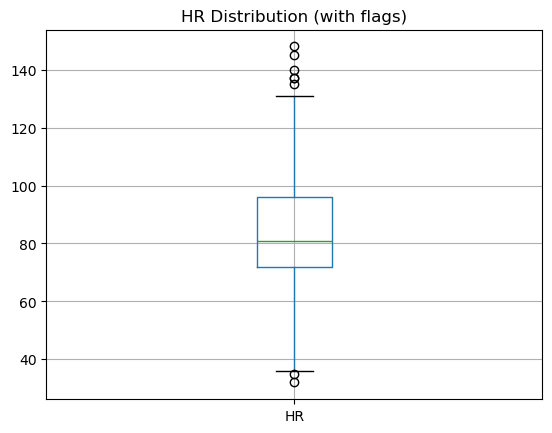

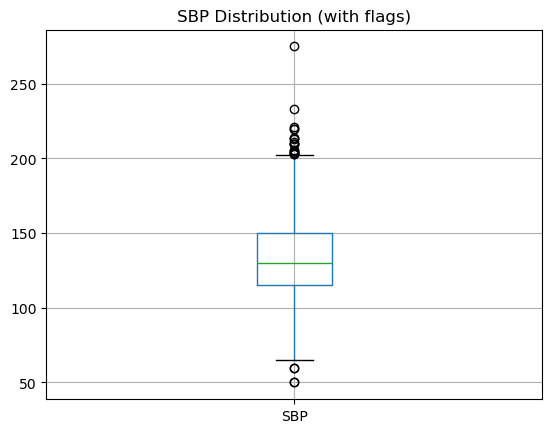

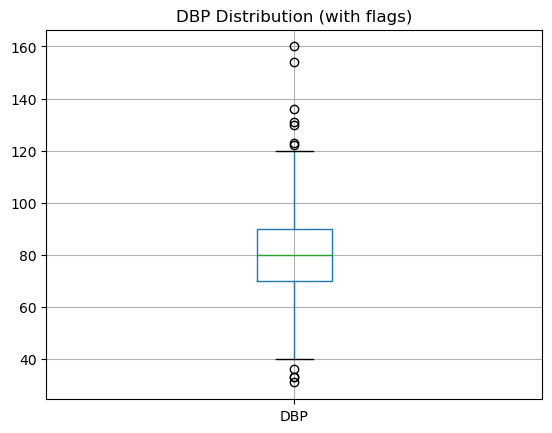

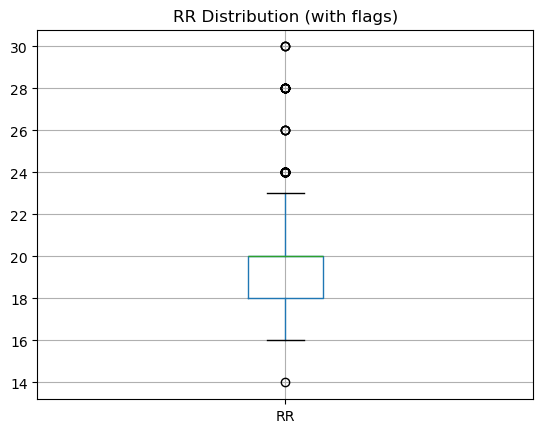

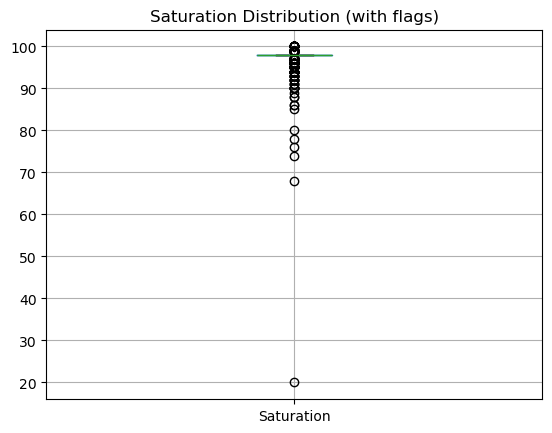

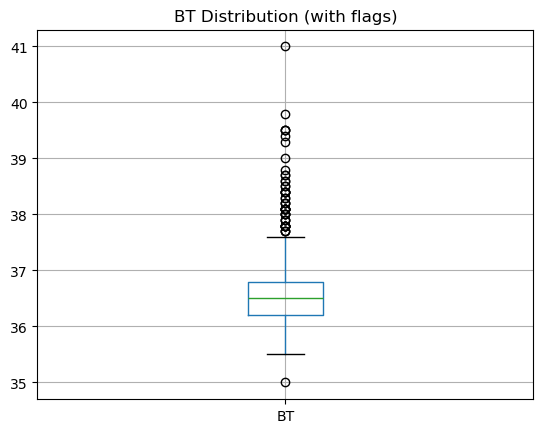

In [434]:
# Loop through each vital sign column to visualize its distribution
for col in vitals:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f"{col} Distribution (with flags)")
    plt.show()

In [435]:
invalid_rows = df[df["invalid_flag"] == True]
vitals = ["HR", "SBP", "DBP", "RR", "Saturation", "BT"]
invalid_rows[vitals]

,HR,SBP,DBP,RR,Saturation,BT
52,80,200,160.0,20,98,36.0
810,120,275,154.0,28,98,38.1
1148,56,130,80.0,20,20,36.2


In [436]:
outlier_rows = df[df["outlier_flag"] == True]
outlier_rows[vitals]

,HR,SBP,DBP,RR,Saturation,BT
0,84,160,100.0,18,100,36.6
5,94,140,90.0,20,98,38.1
9,80,130,80.0,20,97,36.3
17,100,130,80.0,20,97,36.4
23,88,140,80.0,20,97,36.5
...,...,...,...,...,...,...
1260,71,130,80.0,20,100,36.3
1261,74,80,50.0,20,95,36.5
1262,86,120,80.0,22,95,36.4
1263,94,120,80.0,20,97,36.4


In [437]:
vitals = ["HR", "SBP", "DBP", "RR", "Saturation", "BT"]

for col in vitals:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    if (df.loc[0, col] < lower) or (df.loc[0, col] > upper):
        print(f"{col} = {df.loc[0, col]} is an outlier (Lower={lower}, Upper={upper})")

Saturation = 100 is an outlier (Lower=98.0, Upper=98.0)


In [438]:
borderline_rows = df[df["borderline_flag"] == True]
borderline_rows

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,invalid_flag,outlier_flag,borderline_flag
0,2,2,71,3,3,2,right ocular pain,1,1,2,...,Corneal abrasion,1,4,2,86,500,1,False,True,True
7,1,2,78,14,3,1,"pain, chest",1,1,3,...,Acute coronary syndrome,1,3,2,247,1023,1,False,False,True
10,1,2,43,3,3,1,acute epigastric pain,1,1,3,...,Acute gastritis,1,4,4,176,753,1,False,False,True
15,2,1,65,12,4,1,headache,1,1,3,...,"Subarachnoid haemorrhage, unspecified",2,4,4,153,300,1,False,False,True
27,2,2,74,12,4,2,chest wall pain right,1,1,8,...,"Multiple fracture of involving three ribs,Closed",2,2,1,207,400,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2,1,67,7,2,1,general weakness,1,0,3,...,"Spondylopathy in other infectious and parasitic diseases classified elsewhere, lumbar region",2,3,0,10575,200,0,False,False,True
1257,2,1,68,12,3,1,Amnesia,1,0,3,...,Transient global amnesia,1,3,0,9169,300,0,False,True,True
1258,2,2,69,12,2,1,epistaxis,1,0,3,...,Epistaxis,1,3,0,196,500,0,False,True,True
1261,2,2,78,8,4,1,G/W-General weakness,1,0,3,...,Ventricular tachycardia,2,2,0,589,300,0,False,True,True


In [439]:
for col in ["HR","SBP","DBP","RR","Saturation","BT"]:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

In [440]:
# Initialize a new column 'invalid_reason' as an empty string
# This column will store text describing why a row is invalid
df["invalid_reason"] = ""
df.loc[(df["HR"] <= 0) | (df["HR"] > 250), "invalid_reason"] += "HR_out_of_range; "

df.loc[(df["SBP"] < 50) | (df["SBP"] > 260), "invalid_reason"] += "SBP_out_of_range; "

df.loc[(df["DBP"] < 30) | (df["DBP"] > 150), "invalid_reason"] += "DBP_out_of_range; "

df.loc[(df["RR"] <= 0) | (df["RR"] > 60), "invalid_reason"] += "RR_out_of_range; "

df.loc[(df["Saturation"] < 50) | (df["Saturation"] > 100), "invalid_reason"] += "SPO2_out_of_range; "

df.loc[(df["BT"] < 25) | (df["BT"] > 45), "invalid_reason"] += "BT_out_of_range; "

df.loc[
    df[["HR","SBP","DBP","RR","Saturation","BT"]].isna().any(axis=1),
    "invalid_reason"
] += "Missing_vital; "
df["invalid_flag"] = df["invalid_reason"] != ""
df[df["invalid_flag"]][
    ["HR","SBP","DBP","RR","Saturation","BT","invalid_reason"]
].head(10)

,HR,SBP,DBP,RR,Saturation,BT,invalid_reason


In [441]:
print("Invalid rows before deletion:", df["invalid_flag"].sum())
df_clean = df[~df["invalid_flag"]].copy()
print("Invalid rows after deletion:", df_clean["invalid_flag"].sum())

Invalid rows before deletion: 0
Invalid rows after deletion: 0


In [442]:
df_clean.to_csv("cleaned_dataset_2.csv", index=False)

## Dataset Cleaning 3

In [443]:
df = pd.read_csv("cleaned_dataset_2.csv")

In [445]:
# List of columns that we want to remove from the DataFrame
columns_to_drop = [
    'mistriage', 'invalid_flag', 'outlier_flag',
    'borderline_flag', 'review_remove', 'keep', 'invalid_reason'
]

columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop, inplace=True)

print(f"Dropped columns: {columns_to_drop}")

Dropped columns: []


In [446]:
# Check if both 'HR' (Heart Rate) and 'SBP' (Systolic Blood Pressure) columns exist
if 'HR' in df.columns and 'SBP' in df.columns:
    df['Shock_Index'] = df['HR'] / df['SBP']
    print("Derived feature 'Shock_Index' created ")

Derived feature 'Shock_Index' created 


In [448]:
# Identify categorical columns in the DataFrame (dtype 'object' or 'category')
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns encoded: {categorical_cols}")

# Initialize an OrdinalEncoder from scikit-learn
# This encoder converts categorical values to numeric labels (0,1,2,...)
encoder = OrdinalEncoder()

# Apply ordinal encoding to all identified categorical columns
# fit_transform learns the mapping and transforms the data in one step
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

# Print confirmation that encoding is complete
print("Categorical variables encoded using Ordinal Encoding")

Categorical columns encoded: []
Categorical variables encoded using Ordinal Encoding


In [449]:
# Identify numeric columns in the DataFrame (integers and floats)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize a StandardScaler from scikit-learn
# StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Apply scaling to all numeric columns
# fit_transform learns the mean and std from the data and transforms the columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Print confirmation that scaling is complete
print("Numeric features scaled using StandardScaler")

# Print the final shape of the DataFrame after preprocessing
print(f"\nFinal DataFrame shape: {df.shape}")

Numeric features scaled using StandardScaler

Final DataFrame shape: (1267, 24)


In [450]:
df.to_csv("cleaned_dataset_3.csv", index=False)

## Dataset Splitting

In [451]:
data = pd.read_csv("cleaned_dataset_3.csv")

In [452]:
target_col = 'KTAS_RN'
feature_cols = [
    'Group', 'Sex', 'Age', 'Patients number per hour', 'Arrival mode',
    'Injury', 'Chief_complain', 'Mental', 'Pain', 'NRS_pain',
    'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturation', 'Shock_Index'
]

In [453]:
X = data[feature_cols]
y = data[target_col]

In [454]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1013, 17)
X_test shape: (254, 17)
y_train shape: (1013,)
y_test shape: (254,)


In [455]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("Y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("Y_test.csv", index=False)

Baseline Regression Models

In [456]:
X_train = pd.read_csv("X_train.csv")
X_test  = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test  = pd.read_csv("y_test.csv")

In [457]:
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [458]:
#Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
joblib.dump(lr, "Linear_regression_pipeline.pkl")
print("Linear Regression modelr trained and saved.")

Linear Regression modelr trained and saved.


In [459]:
#Ridge Regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)
joblib.dump(ridge, "Ridge_regression_pipeline.pkl")
print("Ridge Regression model trained and saved.")

Ridge Regression model trained and saved.


In [460]:
#Lasso Regression model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)
joblib.dump(lasso, "Lasso_regression_pipeline.pkl")
print("Lasso Regression model trained and saved.")

Lasso Regression model trained and saved.


Regressors Model Training

In [461]:
# Decision tree regressor

# Load training data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
y_train = y_train.values.flatten()

# Train model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Save model
joblib.dump(dt_model, "decision_tree_model.pkl")
print("Decision Tree Regressor trained and saved.")

Decision Tree Regressor trained and saved.


In [462]:
#Random Forest regressor

# Train model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Save model
joblib.dump(rf_model, "random_forest_model.pkl")
print("Random Forest Regressor trained and saved.")

Random Forest Regressor trained and saved.


In [463]:
#Gradient Boosting Regressor

# Train model
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Save model
joblib.dump(gb_model, "gradient_boosting.pkl")
print("Gradient Boosting Regressor trained and saved.")

Gradient Boosting Regressor trained and saved.


In [464]:
#XGBoost Regressor

# Train model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Save model
joblib.dump(xgb_model, "xgboost_model.pkl")
print("XGBoost Regressor trained and saved.")

XGBoost Regressor trained and saved.


In [465]:
# Create ensemble using RF, GB, XGB
ensemble_model = VotingRegressor(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('xgb', xgb_model)
    ]
)

# Train ensemble
ensemble_model.fit(X_train, y_train)

# Save ensemble
joblib.dump(ensemble_model, "ensemble_pipeline.pkl")
print("Ensemble Regressor trained and saved.")

Ensemble Regressor trained and saved.


In [466]:
#SVR model

# Load training data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
y_train = y_train.values.flatten()

# Train SVR model
svm_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svm_model.fit(X_train, y_train)

# Save model
joblib.dump(svm_model, "svm_model.pkl")
print("SVR model trained and saved.")

SVR model trained and saved.


In [467]:
#KNN regressor model

# Train KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_model.fit(X_train, y_train)

# Save model
joblib.dump(knn_model, "knn_model.pkl")
print("KNN Regressor trained and saved.")

KNN Regressor trained and saved.


## Model Evaluation

In [468]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv") 

In [469]:
#  Define Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, rmse, mae, r2

In [470]:
print(os.getcwd())  # shows the folder Python is running in
print(os.listdir())  # shows all files in that folder

C:\Users\ASUS
['.anaconda', '.conda', '.continuum', '.ipynb_checkpoints', '.ipython', '.junie', '.jupyter', '.matplotlib', '.vscode', '@Basic Soft', 'anaconda3', 'anaconda_projects', 'AppData', 'Application Data', 'C++ Tutorials', 'cleaned_dataset_1.csv', 'cleaned_dataset_2.csv', 'cleaned_dataset_3.csv', 'Contacts', 'Cookies', 'Dataset triage.csv', 'decision_tree_model.pkl', 'Desktop', 'Documents', 'Downloads', 'ensemble_pipeline.pkl', 'Favorites', 'gradient_boosting.pkl', 'knn_model.pkl', 'Lasso_regression_pipeline.pkl', 'Linear_regression_pipeline.pkl', 'Links', 'Local Settings', 'Machine Learning', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{091b3c52-c8c5-11f0-8974-fcbd422b62d7}.TM.blf', 'NTUSER.DAT{091b3c52-c8c5-11f0-8974-fcbd422b62d7}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{091b3c52-c8c5-11f0-8974-fcbd422b62d7}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'Pictures', 'PrintHood', '

In [471]:
# Load All Models 
model_files = [
    "decision_tree_model.pkl",
    "ensemble_pipeline.pkl",
    "gradient_boosting.pkl",
    "knn_model.pkl",
    "Lasso_regression_pipeline.pkl",
    "Linear_regression_pipeline.pkl",
    "random_forest_model.pkl",
    "Ridge_regression_pipeline.pkl",
    "svm_model.pkl",
    "xgboost_model.pkl"
]

In [472]:
# Loads multiple machine learning models from disk into a dictionary, handling missing or corrupted files gracefully.
models = {}
for file in model_files:
    try:
        # get only the filename without extension
        key = os.path.splitext(os.path.basename(file))[0]
        models[key] = joblib.load(file)
        print(f"Loaded {key}")
    except FileNotFoundError:
        print(f"WARNING: {file} not found, skipping.")
    except Exception as e:
        print(f"ERROR loading {file}: {e}")

Loaded decision_tree_model
Loaded ensemble_pipeline
Loaded gradient_boosting
Loaded knn_model
Loaded Lasso_regression_pipeline
Loaded Linear_regression_pipeline
Loaded random_forest_model
Loaded Ridge_regression_pipeline
Loaded svm_model
Loaded xgboost_model


In [473]:
# Evaluate Models & Visualize
results = []

for name, model in models.items():
    print(f"\nEvaluating {name} ...")
    y_pred, rmse, mae, r2 = evaluate_model(model, X_test, y_test)
    
    # Save metrics
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
print(results)


Evaluating decision_tree_model ...

Evaluating ensemble_pipeline ...

Evaluating gradient_boosting ...

Evaluating knn_model ...

Evaluating Lasso_regression_pipeline ...

Evaluating Linear_regression_pipeline ...

Evaluating random_forest_model ...

Evaluating Ridge_regression_pipeline ...

Evaluating svm_model ...

Evaluating xgboost_model ...
[{'Model': 'decision_tree_model', 'RMSE': np.float64(1.2502583657802921), 'MAE': 0.8941261029881352, 'R2': -0.30454312750813295}, {'Model': 'ensemble_pipeline', 'RMSE': np.float64(0.8729788012291975), 'MAE': 0.6806619503939897, 'R2': 0.36398655234977406}, {'Model': 'gradient_boosting', 'RMSE': np.float64(0.8703875791851641), 'MAE': 0.6810251026432754, 'R2': 0.36775664652777407}, {'Model': 'knn_model', 'RMSE': np.float64(0.9555817240185421), 'MAE': 0.748898988664456, 'R2': 0.23793051306435853}, {'Model': 'Lasso_regression_pipeline', 'RMSE': np.float64(0.9626732672917854), 'MAE': 0.7653122995104233, 'R2': 0.22657763437939793}, {'Model': 'Linear_

In [475]:
# Converts model evaluation results into a DataFrame, normalizes metrics, computes a composite score to rank models, and sorts them for comparison.
results_df = pd.DataFrame(results)

# Normalize metrics
results_df['RMSE_norm'] = results_df['RMSE'] / results_df['RMSE'].max()
results_df['R2_norm']   = (results_df['R2'] - results_df['R2'].min()) / (
                           results_df['R2'].max() - results_df['R2'].min())

# Composite score (higher is better)
results_df['Score'] = results_df['R2_norm'] - results_df['RMSE_norm']

# Sort
results_df = results_df.sort_values(by='Score', ascending=False)

print(results_df[['Model','RMSE','MAE','R2','Score']])

                        Model      RMSE       MAE        R2     Score
2           gradient_boosting  0.870388  0.681025  0.367757  0.303834
1           ensemble_pipeline  0.872979  0.680662  0.363987  0.296154
9               xgboost_model  0.897383  0.698526  0.327930  0.223003
6         random_forest_model  0.905329  0.713633  0.315975  0.198866
3                   knn_model  0.955582  0.748899  0.237931  0.042585
4   Lasso_regression_pipeline  0.962673  0.765312  0.226578  0.020026
7   Ridge_regression_pipeline  0.965888  0.762533  0.221404  0.009760
5  Linear_regression_pipeline  0.966160  0.762663  0.220966  0.008890
8                   svm_model  1.104197  0.872053 -0.017542 -0.456281
0         decision_tree_model  1.250258  0.894126 -0.304543 -1.000000


In [476]:
# Define evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, rmse, mae, r2


Evaluating decision_tree_model ...


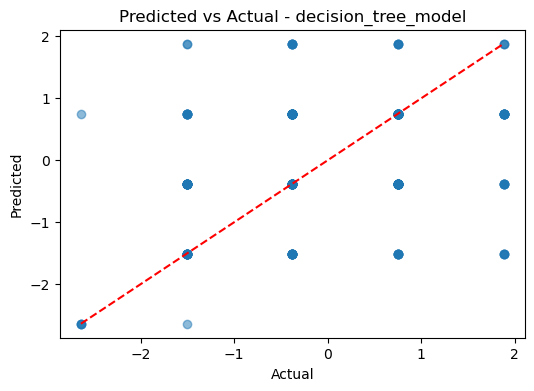

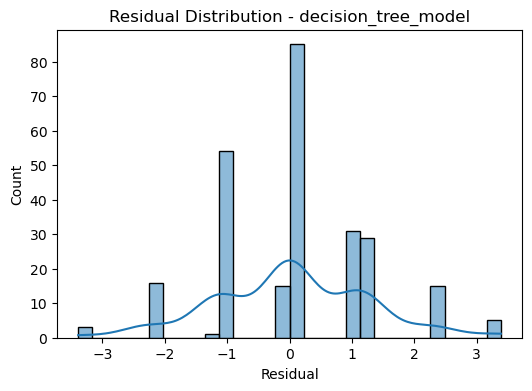


Evaluating ensemble_pipeline ...


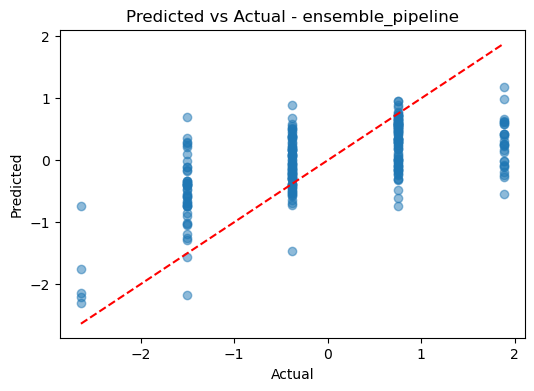

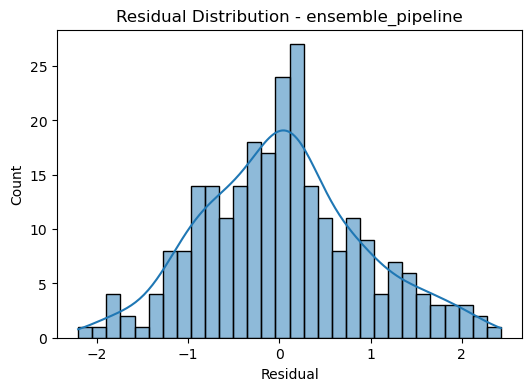


Evaluating gradient_boosting ...


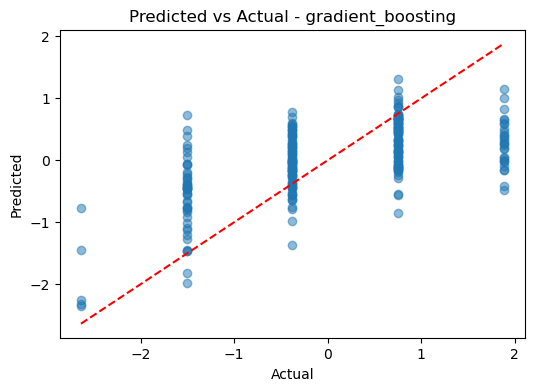

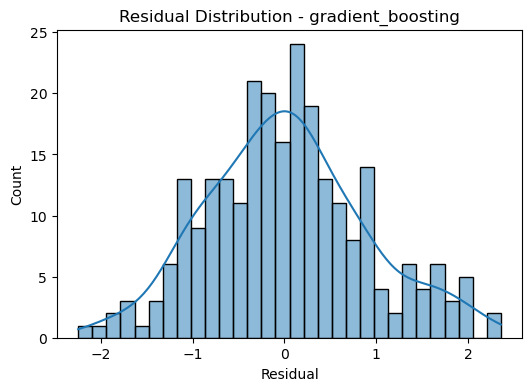


Evaluating knn_model ...


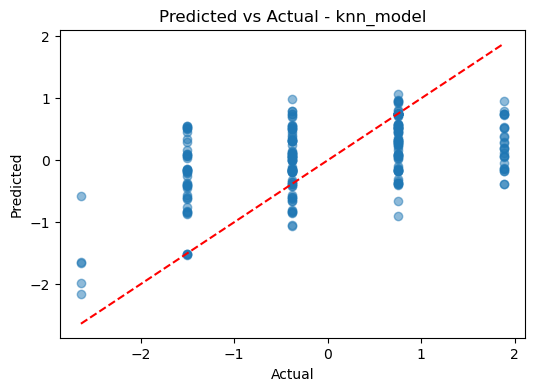

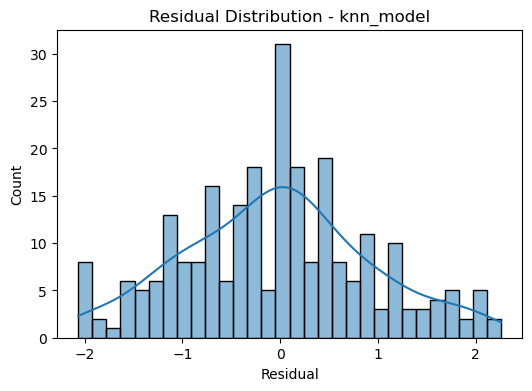


Evaluating Lasso_regression_pipeline ...


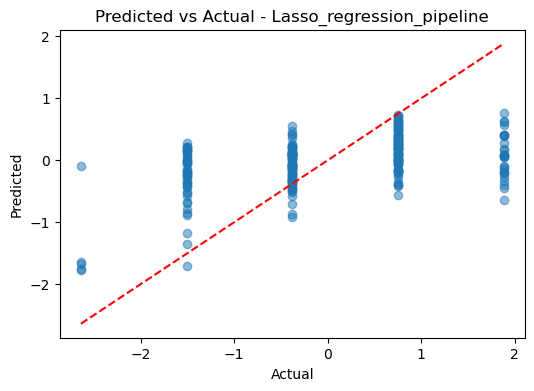

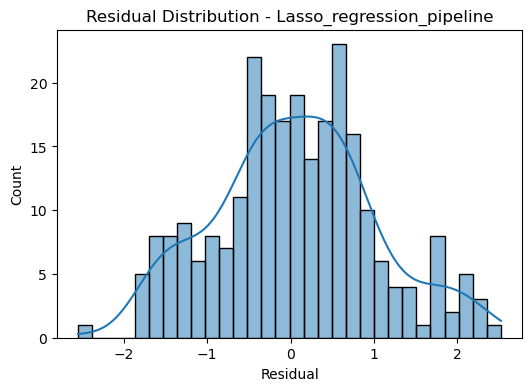


Evaluating Linear_regression_pipeline ...


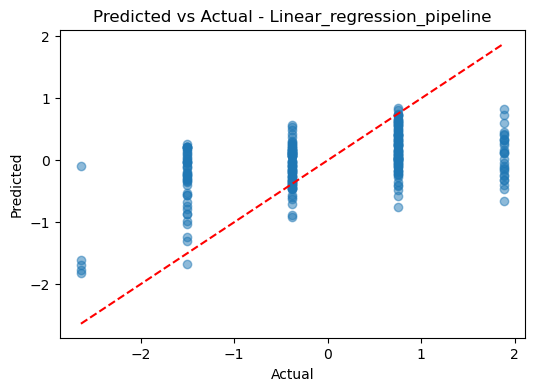

C:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


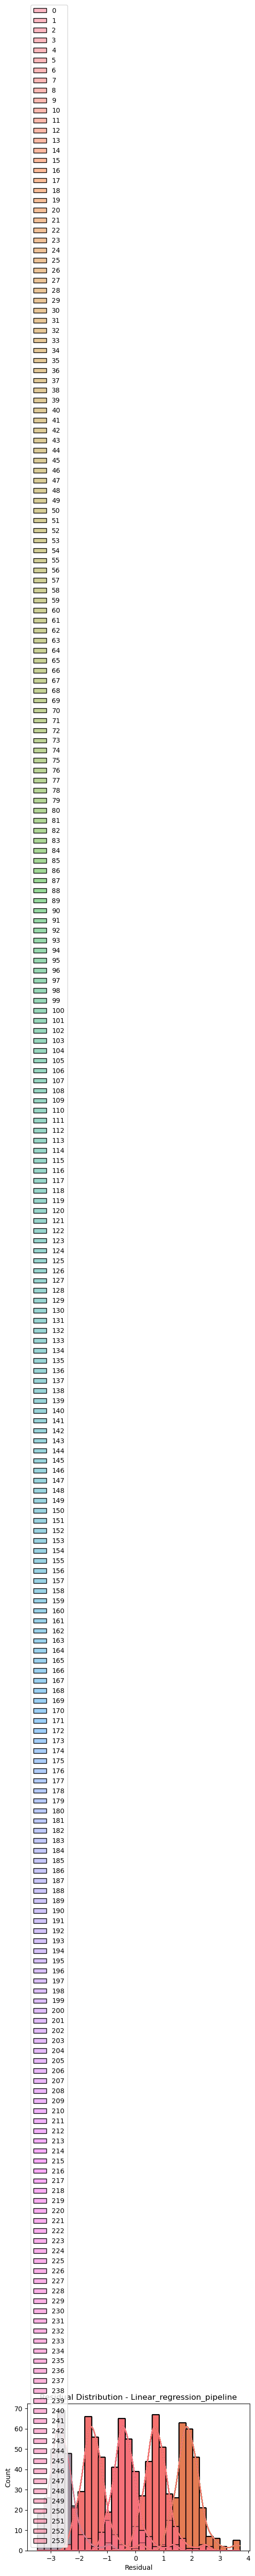


Evaluating random_forest_model ...


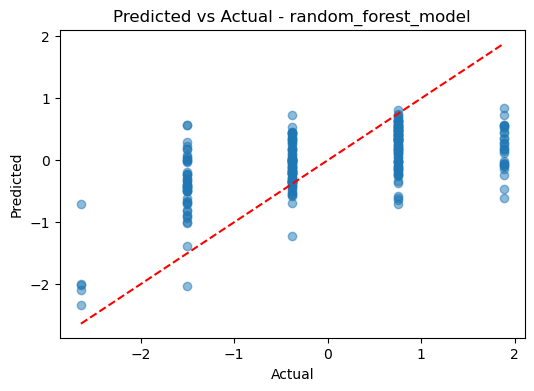

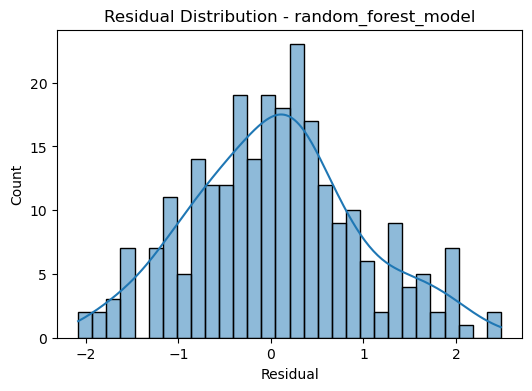


Evaluating Ridge_regression_pipeline ...


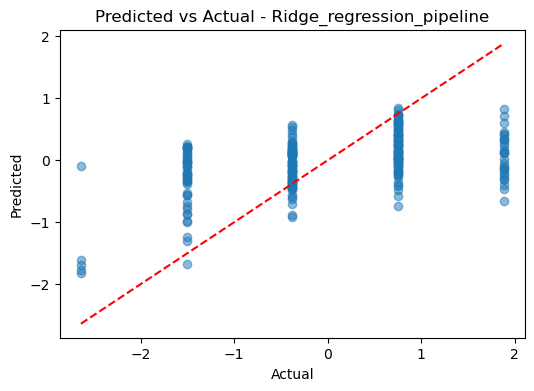

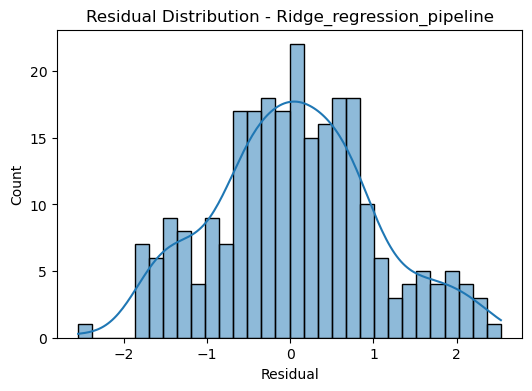


Evaluating svm_model ...


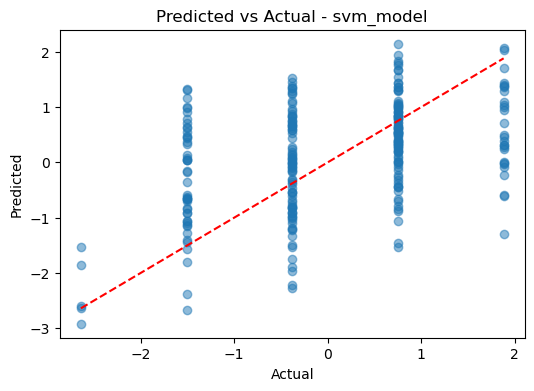

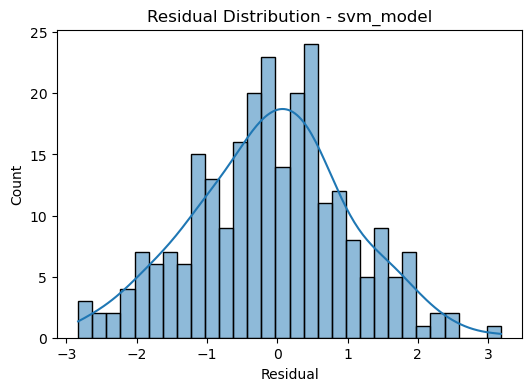


Evaluating xgboost_model ...


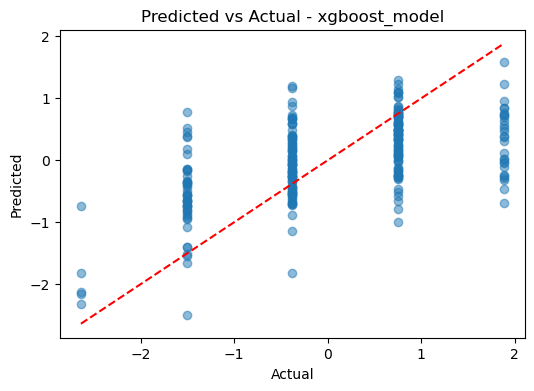

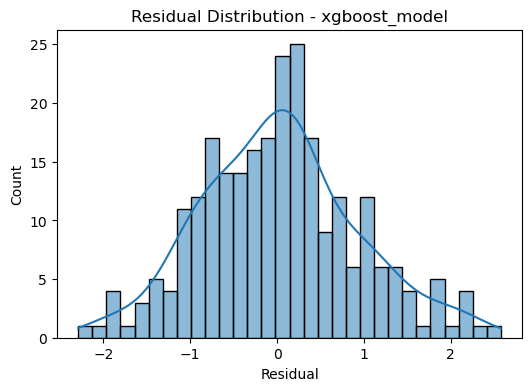

In [479]:
# Evaluate all models
results = []

for name, model in models.items():
    print(f"\nEvaluating {name} ...")

    y_pred, rmse, mae, r2 = evaluate_model(model, X_test, y_test)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

    # ---------- Predicted vs Actual ----------
    y_test_flat = np.asarray(y_test).ravel()

    plt.figure(figsize=(6,4))
    plt.scatter(y_test_flat, y_pred, alpha=0.5)
    plt.plot(
        [y_test_flat.min(), y_test_flat.max()],
        [y_test_flat.min(), y_test_flat.max()],
        'r--'
    )
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual - {name}")
    plt.show()

    # ---------- Residual Distribution ----------
    residuals = y_test_flat - y_pred

    plt.figure(figsize=(6,4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.xlabel("Residual")
    plt.title(f"Residual Distribution - {name}")
    plt.show()


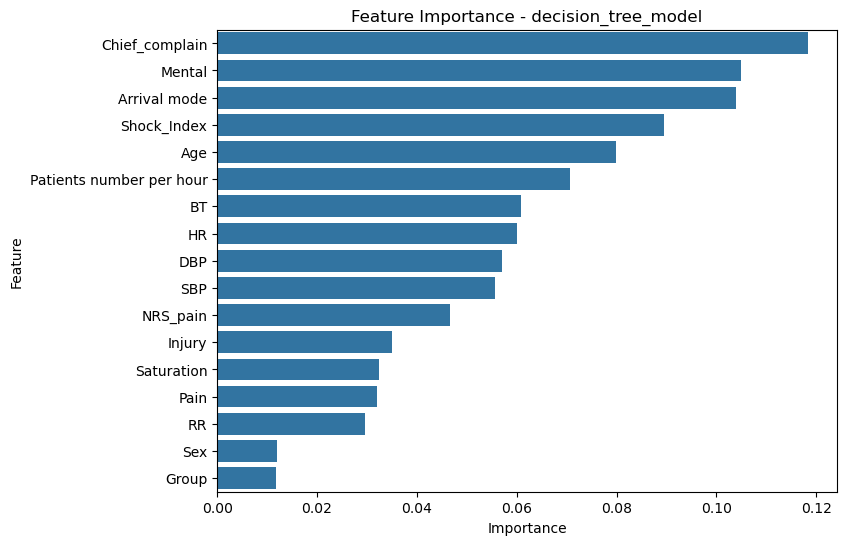

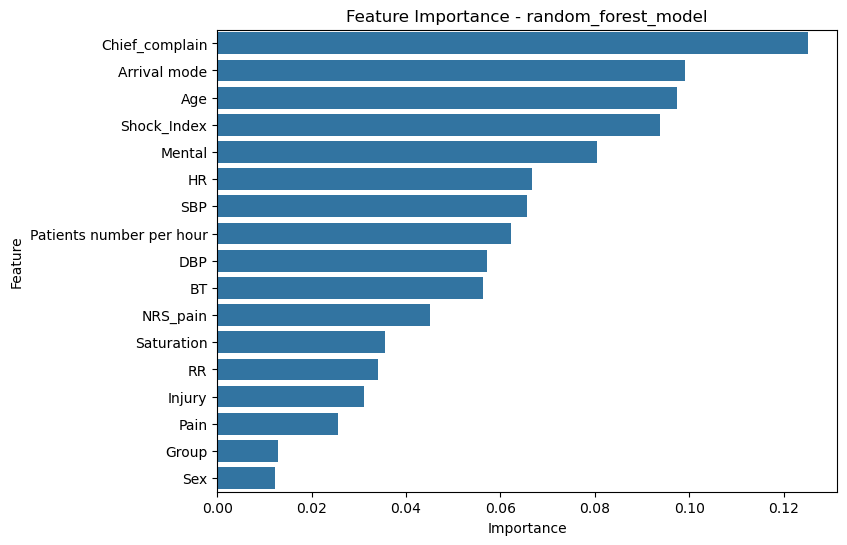

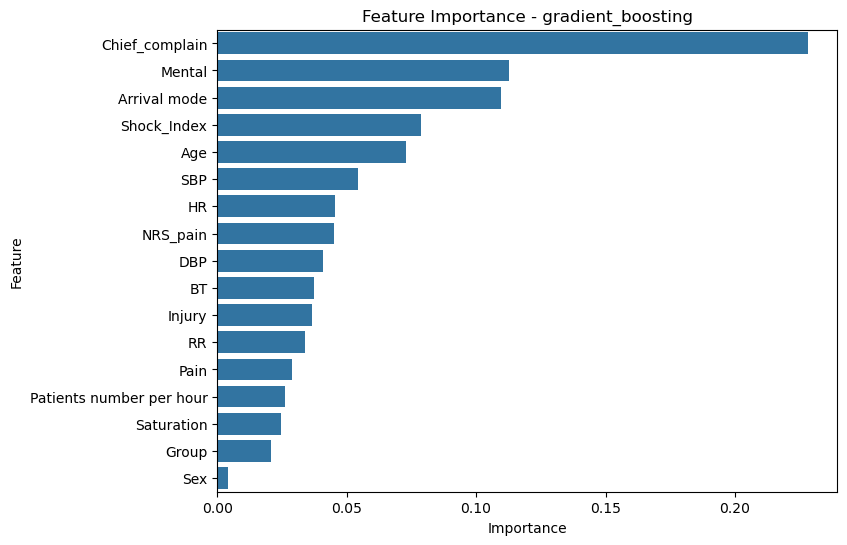

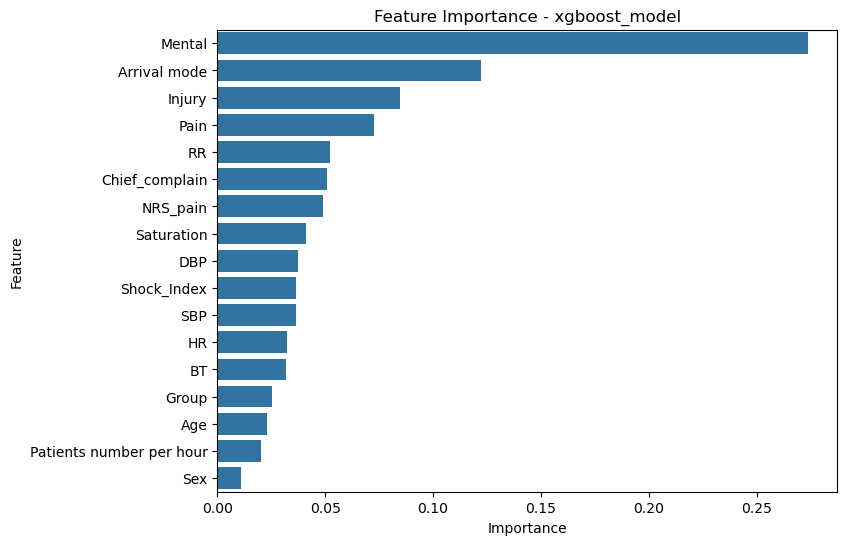

In [480]:
# Feature importance for tree-based models
tree_models = ['decision_tree_model','random_forest_model','gradient_boosting','xgboost_model']

for name in tree_models:
    model = models.get(name)
    if model and hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': importances})
        feat_df = feat_df.sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(8,6))
        sns.barplot(x='Importance', y='Feature', data=feat_df)
        plt.title(f'Feature Importance - {name}')
        plt.show()
    else:
        print(f"Skipping {name} (no feature_importances_)")

In [481]:
# Create results table
results_df = pd.DataFrame(results)
results_df.columns = [col.strip() for col in results_df.columns]  # clean column names

In [482]:
# Compute composite score for fair ranking
# Normalize RMSE (lower better) and R2 (higher better)
results_df['RMSE_norm'] = results_df['RMSE'] / results_df['RMSE'].max()
results_df['R2_norm'] = (results_df['R2'] - results_df['R2'].min()) / (results_df['R2'].max() - results_df['R2'].min())

# Composite score: higher = better
results_df['Score'] = results_df['R2_norm'] - results_df['RMSE_norm']

# Sort by composite score
results_df = results_df.sort_values(by='Score', ascending=False)

# Display ranking
print("\nModel Ranking (Composite Score - higher is better):")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
print(results_df[['Model','RMSE','MAE','R2','Score']])


Model Ranking (Composite Score - higher is better):
                        Model      RMSE       MAE        R2     Score
2           gradient_boosting  0.870388  0.681025  0.367757  0.303834
1           ensemble_pipeline  0.872979  0.680662  0.363987  0.296154
9               xgboost_model  0.897383  0.698526  0.327930  0.223003
6         random_forest_model  0.905329  0.713633  0.315975  0.198866
3                   knn_model  0.955582  0.748899  0.237931  0.042585
4   Lasso_regression_pipeline  0.962673  0.765312  0.226578  0.020026
7   Ridge_regression_pipeline  0.965888  0.762533  0.221404  0.009760
5  Linear_regression_pipeline  0.966160  0.762663  0.220966  0.008890
8                   svm_model  1.104197  0.872053 -0.017542 -0.456281
0         decision_tree_model  1.250258  0.894126 -0.304543 -1.000000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1928\495883756.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette='coolwarm')


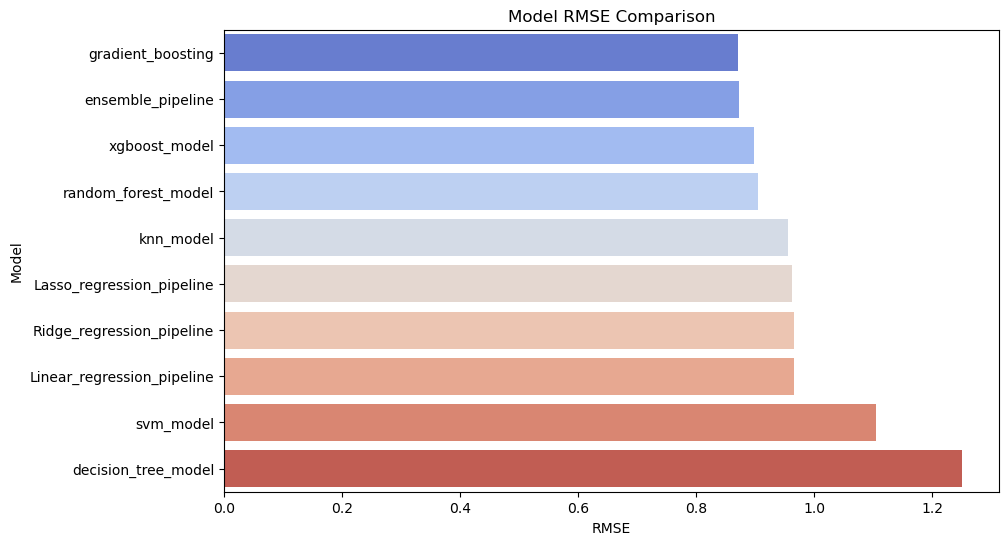

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1928\495883756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_df, palette='viridis')


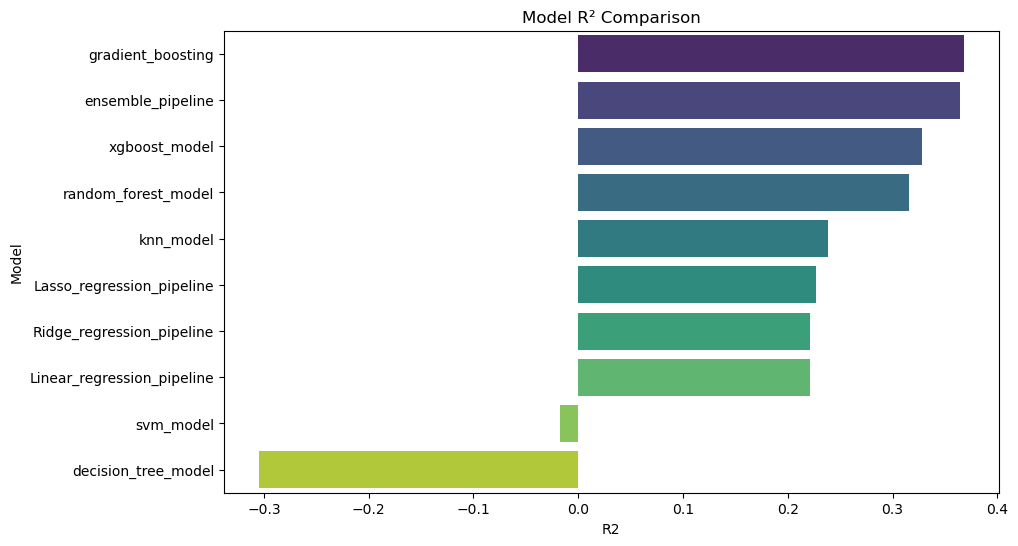

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1928\495883756.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Model', data=results_df, palette='magma')


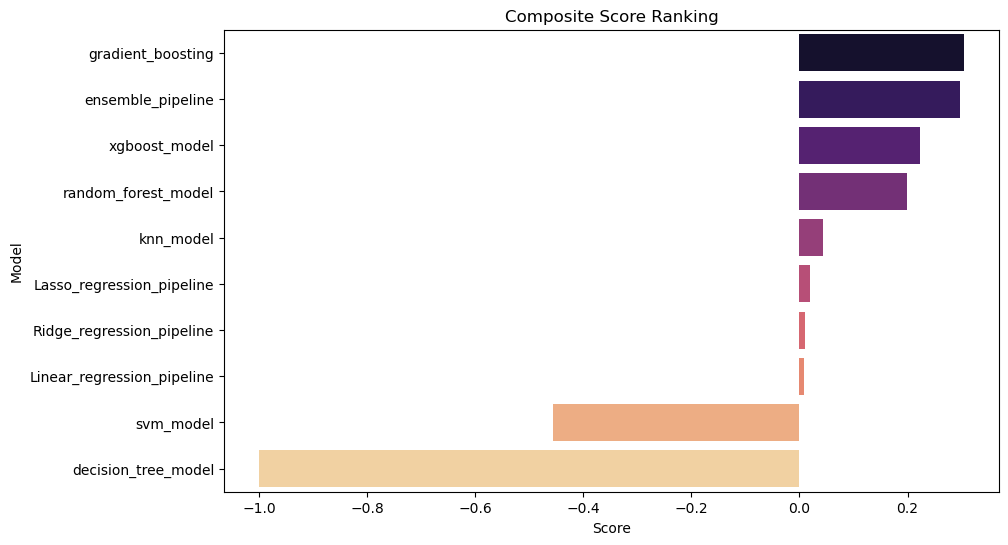

In [483]:
# Visual comparison: RMSE, R2, Score
plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='coolwarm')
plt.title("Model RMSE Comparison")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='R2', y='Model', data=results_df, palette='viridis')
plt.title("Model R² Comparison")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Score', y='Model', data=results_df, palette='magma')
plt.title("Composite Score Ranking")
plt.show()

In [484]:
# Load datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('Y_train.csv').squeeze()
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('Y_test.csv').squeeze()

In [485]:
# Engineered features expected by model
required_features = ['Low_SBP', 'High_HR', 'Error_group', 'KTAS_RN', 'KTAS_expert',
                     'Pain_Injury', 'Age_KTAS', 'Low_Saturation', 'Diagnosis in ED',
                     'Crowding_Index', 'Disposition', 'KTAS duration_min']

In [486]:
# Fill missing columns
for col in required_features:
    if col not in X_train.columns:
        X_train[col] = 0
    if col not in X_test.columns:
        X_test[col] = 0

In [487]:
# Ensure same column order
X_train = X_train[sorted(X_train.columns)]
X_test  = X_test[sorted(X_train.columns)]

In [488]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [489]:
# Tree-based
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Linear models
lasso = Lasso(alpha=0.01, max_iter=10000)
ridge = Ridge(alpha=1.0, max_iter=10000)

In [490]:
# Creates a stacking ensemble model by combining multiple base regressors, using Ridge regression as the meta-learner to improve predictive performance.
estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lasso', lasso),
    ('ridge', ridge)
]

stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),  
    n_jobs=-1
)

In [491]:
stacked_model.fit(X_train_scaled, y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,final_estimator,Ridge()
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1


In [492]:
def evaluate(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}\n")
    return rmse, mae, r2

# Predict
y_pred = stacked_model.predict(X_test_scaled)
evaluate(y_test, y_pred, "Stacked Ensemble Improved Model")

Stacked Ensemble Improved Model Metrics:
RMSE: 0.8771
MAE: 0.6912
R²: 0.3580



(np.float64(0.8770910503926626), 0.6911883262754926, 0.3579804364701641)

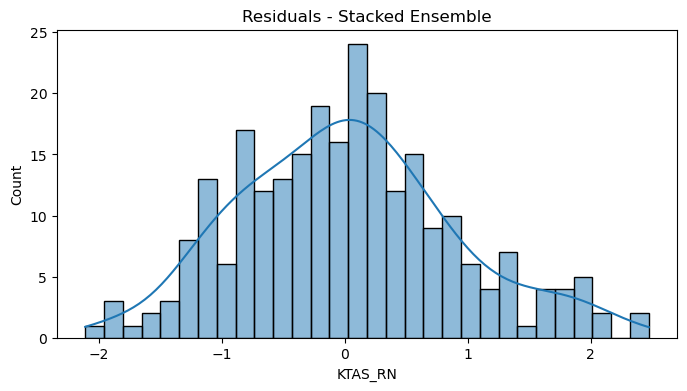

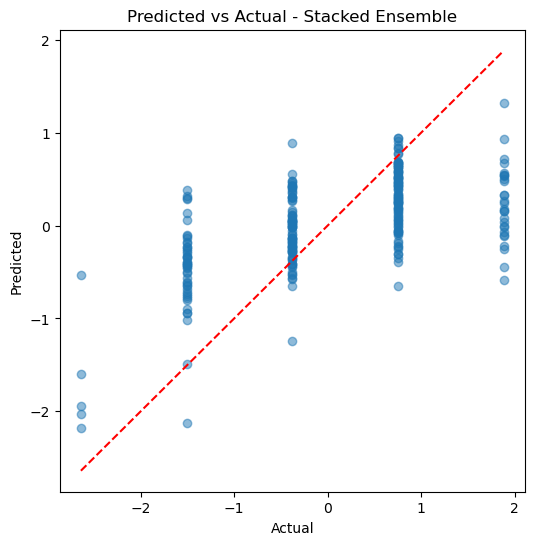

In [493]:
residuals = y_test - y_pred

plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals - Stacked Ensemble")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual - Stacked Ensemble")
plt.show()

In [494]:
joblib.dump(stacked_model, 'stacked_model_improved.joblib')
joblib.dump(scaler, 'scaler_improved.joblib')

['scaler_improved.joblib']

In [495]:
final_model = joblib.load('scaler_improved.joblib')
print(type(final_model))

<class 'sklearn.preprocessing._data.StandardScaler'>


In [496]:
stacked_model = joblib.load("stacked_model_improved.joblib")
scaler = joblib.load("scaler_improved.joblib")

In [497]:
print([v for v in globals().keys() if v.startswith("X_") or v.startswith("y_")])

['X_train', 'X_test', 'y_train', 'y_test', 'X_train_scaled', 'X_test_scaled', 'y_pred_lr', 'y_pred', 'y_pred_ridge', 'y_pred_lasso', 'y_test_flat']


In [498]:
y_pred = stacked_model.predict(X_test_scaled)

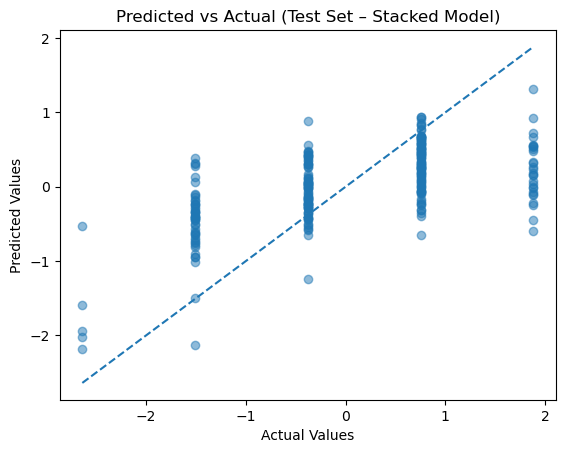

In [499]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Test Set – Stacked Model)")
plt.show()

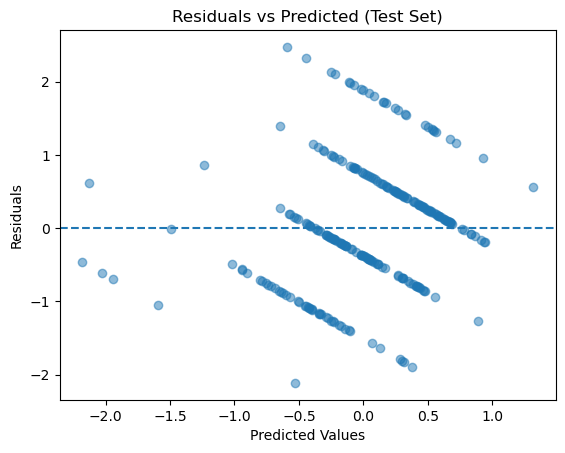

In [500]:
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Test Set)")
plt.show()

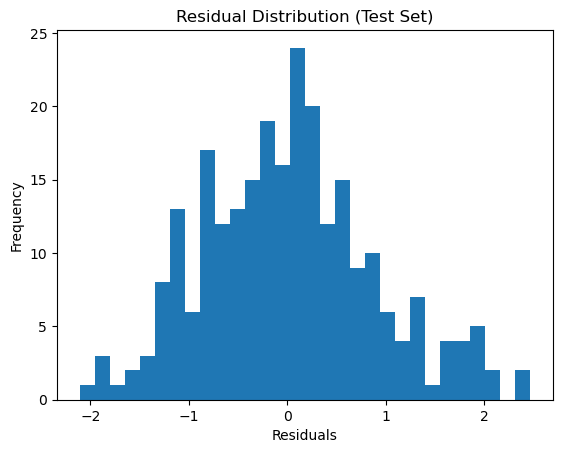

In [501]:
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Test Set)")
plt.show()

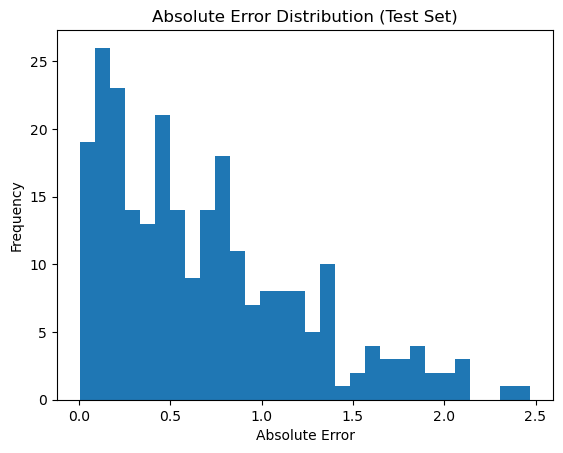

In [502]:
absolute_errors = np.abs(residuals)

plt.figure()
plt.hist(absolute_errors, bins=30)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Absolute Error Distribution (Test Set)")
plt.show()

In [503]:
start_time = time.time()
stacked_model.predict(X_test_scaled)
inference_time = time.time() - start_time

print("🖥️ Computational Constraints")
print(f"Test Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_test.shape[1]}")
print(f"Inference Time: {inference_time:.4f} seconds")

🖥️ Computational Constraints
Test Samples: 254
Number of Features: 29
Inference Time: 0.0343 seconds
